In [ ]:
import torch
from torchvision import datasets, transforms
from torchvision.datasets.coco import CocoDetection
from torch.utils.data import DataLoader

# Define the path to the dataset
data_dir = './data-coco/CoCO-dataset/coco2017'  # Path to your "data" folder
train_dir = f'{data_dir}/train2017'
val_dir = f'{data_dir}/val2017'
ann_file_train = f'{data_dir}/annotations/instances_train2017.json'
ann_file_val = f'{data_dir}/annotations/instances_val2017.json'

print("data dir done")
# Define a fixed image size (e.g., 256x256)
fixed_size = (256, 256)

# Define data transformations including resizing
transform = transforms.Compose([
    transforms.Resize(fixed_size),  # Resize images to the fixed size
    transforms.ToTensor(),  # Convert PIL images to tensors
])

print("data-transfor done")
# Load the COCO dataset
coco_train = CocoDetection(root=train_dir, annFile=ann_file_train, transform=transform)
coco_val = CocoDetection(root=val_dir, annFile=ann_file_val, transform=transform)

# Custom collate function to handle batches with different sizes of annotations
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)  # Stack images into a single tensor
    return images, targets  # Targets are left as is (list of varying lengths)


print("collate done")
# Create DataLoader for training and validation sets with the custom collate function
# train_loader = DataLoader(coco_train, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
# val_loader = DataLoader(coco_val, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

train_loader = DataLoader(coco_train, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(coco_val, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)

print("data load done")
# Test the DataLoader
for images, targets in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of targets: {targets}")
    break  # Break after one batch for testing purposes


In [ ]:
# Print the structure of targets to understand its format
for images, targets in train_loader:
    print("Targets structure:", targets)
    break  # Check the first batch only


In [ ]:
# Print the structure of the targets
for images, targets in train_loader:
    print("Images shape:", images.shape)  # Check the shape of the images
    print("Targets structure:", targets)  # Check the targets
    break  # Check only the first batch


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def visualize_image_with_boxes(image, targets):
    # Transform the image to displayable format
    image = T.ToPILImage()(image)

    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Loop over all targets in the batch (if applicable)
    for target in targets:
        # Ensure target is a dictionary
        if isinstance(target, dict):
            # Extract boxes and labels from target
            boxes = target['boxes'].cpu().numpy()  # Ensure to move to CPU if using GPU
            labels = target['labels'].cpu().numpy()  # Ensure to move to CPU if using GPU
            
            # Loop over bounding boxes and add them to the plot
            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = box
                # Create a Rectangle patch
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                         linewidth=2, edgecolor='r', facecolor='none')
                # Add the rectangle to the plot
                ax.add_patch(rect)
                
                # Get the class label name
                class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
                
                # Add class name label above the bounding box
                plt.text(xmin, ymin, class_name, fontsize=10, color='white', 
                         bbox=dict(facecolor='red', alpha=0.5))
        else:
            print("Target is not a dictionary:", target)  # Debugging line to understand the structure

    # Show the plot
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# Iterate over the data in train_loader to visualize one sample
for images, targets in train_loader:
    image = images[0]   # Take the first image from the batch
    target = targets[0]  # Take the corresponding target (assuming it's a list of targets)
    visualize_image_with_boxes(image, targets)  # Pass the entire list of targets
    break  # Just show one image for now


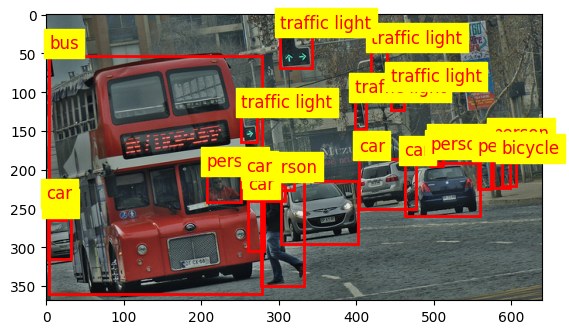

In [12]:
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Set the data directory path
data_dir = './data-coco/CoCO-dataset/coco2017'

# Load the COCO annotation file (instances_train2017.json)
annotation_file = f'{data_dir}/annotations/instances_train2017.json'
with open(annotation_file) as f:
    coco_data = json.load(f)

# Get the image metadata, annotations, and categories
images = coco_data['images']
annotations = coco_data['annotations']
categories = coco_data['categories']

# Let's randomly pick an image that exists in the dataset
image_info = random.choice(images)  # Pick a random image from the images list
image_id = image_info['id']         # Get the image ID
image_file = f'{data_dir}/train2017/{image_info["file_name"]}'

# Open the image
img = Image.open(image_file)

# Plot the image
fig, ax = plt.subplots(1)
ax.imshow(img)

# Find all annotations for this image
image_annotations = [ann for ann in annotations if ann['image_id'] == image_id]

# Loop through each annotation and draw the bounding box
for ann in image_annotations:
    # Get bounding box coordinates
    bbox = ann['bbox']  # Format: [x, y, width, height]
    category_id = ann['category_id']
    
    # Find the category name for this object
    category_name = next(cat['name'] for cat in categories if cat['id'] == category_id)
    
    # Create a Rectangle patch for the bounding box
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the bounding box to the image
    ax.add_patch(rect)
    
    # Add category name on top of the bounding box
    plt.text(bbox[0], bbox[1] - 10, category_name, color='red', fontsize=12, backgroundcolor='yellow')

# Show the image with bounding boxes and labels
plt.show()


In [9]:
# Print the selected image info to inspect
print(image_info)


{'license': 3, 'file_name': '000000033042.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000033042.jpg', 'height': 444, 'width': 640, 'date_captured': '2013-11-21 23:49:36', 'flickr_url': 'http://farm2.staticflickr.com/1228/5141739650_34bba93a15_z.jpg', 'id': 33042}


# Use pretrain yolov5 model and do some predictions

Using cache found in C:\Users\Lenovo/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-10-25 Python-3.12.4 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


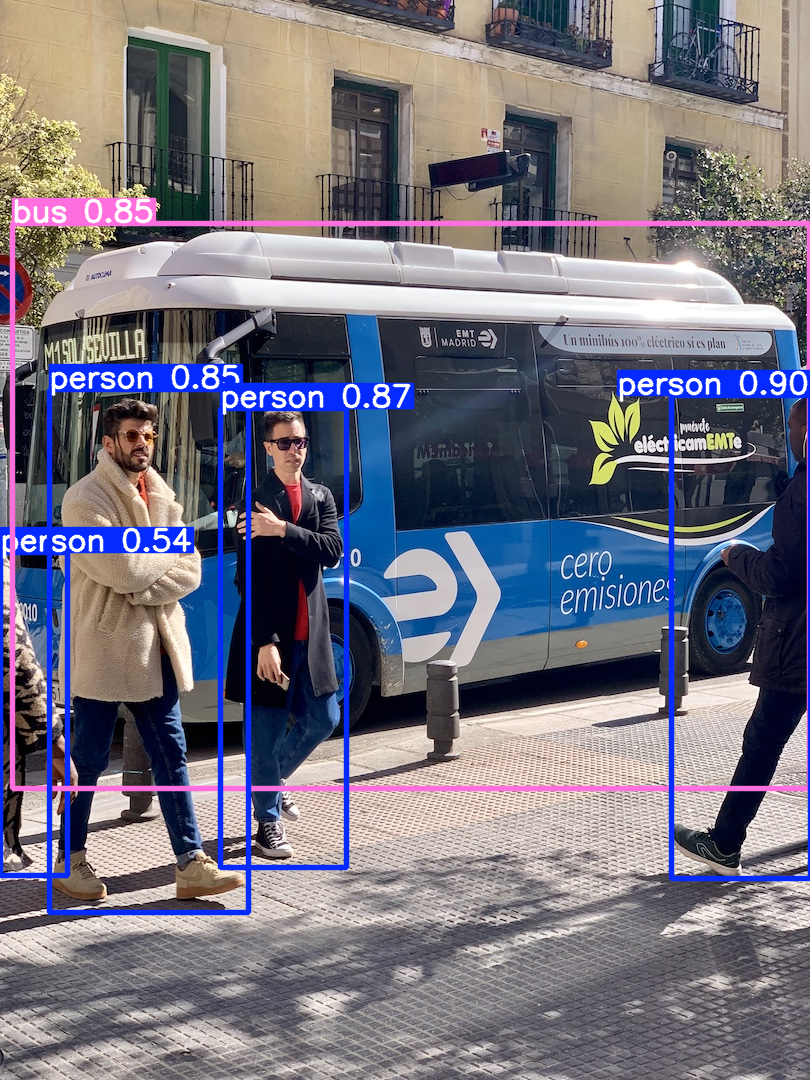

In [6]:
# Import required libraries
import torch
from IPython.display import Image  # To display images in Jupyter notebook

# Load a pre-trained YOLOv5 model (small version - 'yolov5s')
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Define the path to your image (replace with your own image path if needed)
img_path = '../yolov5/data/images/bus.jpg'  # Example image in the yolov5/data/images folder

# Run inference
results = model(img_path)

# Display the result
results.show()  # This will display the image with bounding boxes in Jupyter
